In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 
# Separando o texto da variável alvo 
list_corpus = clean_questions["text"].tolist() 
list_labels = clean_questions["class_label"].tolist() 
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)                                                           
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

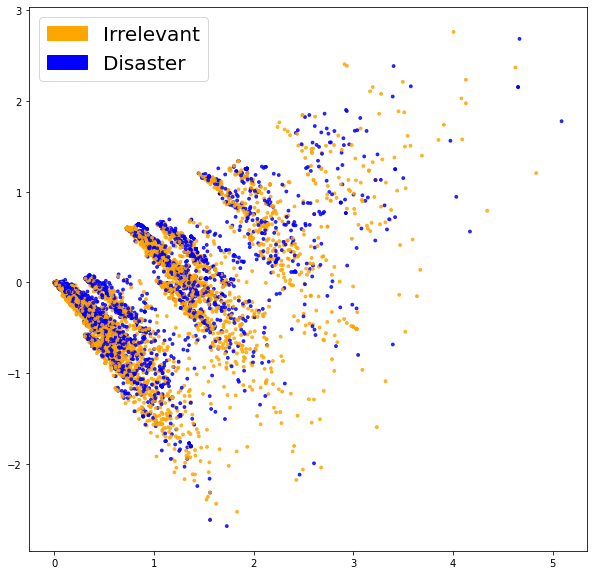

In [ ]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})
            
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [ ]:
# Aplicando configurações no modelo
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

#Treinando o modelo com o vocabulário construindo e as variáveis alvo
clf.fit(X_train_counts, y_train)

#Realizando as predições para o conjunto de teste
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste.
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


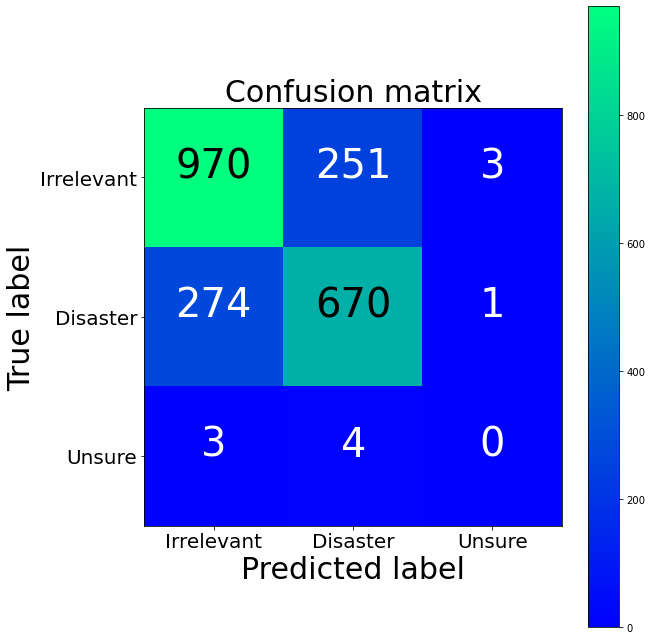

Count Vectorizer confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [ ]:
#Método para plotar a matriz de confusão.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Count Vectorizer confusion matrix")
print(cm)

In [ ]:
# Método para identificação das features mais importantes na tomada de decisão.
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

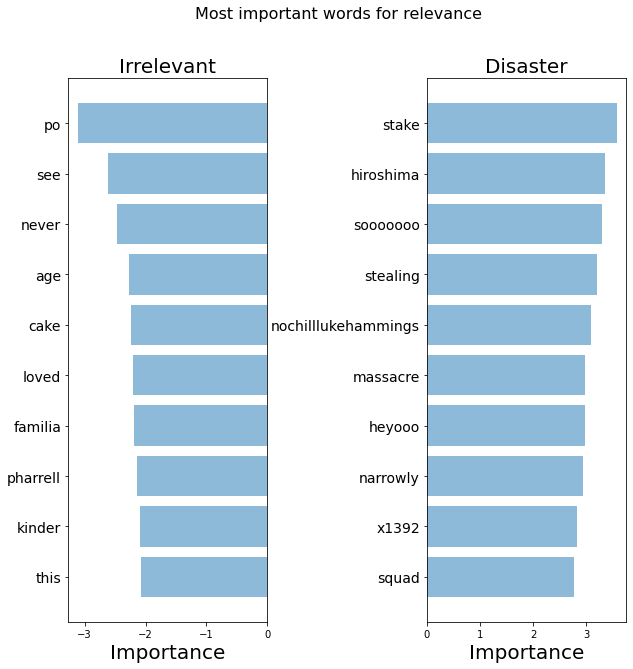

In [ ]:
# Método para plotar as featrues mais importantes para cada variável alvo.
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

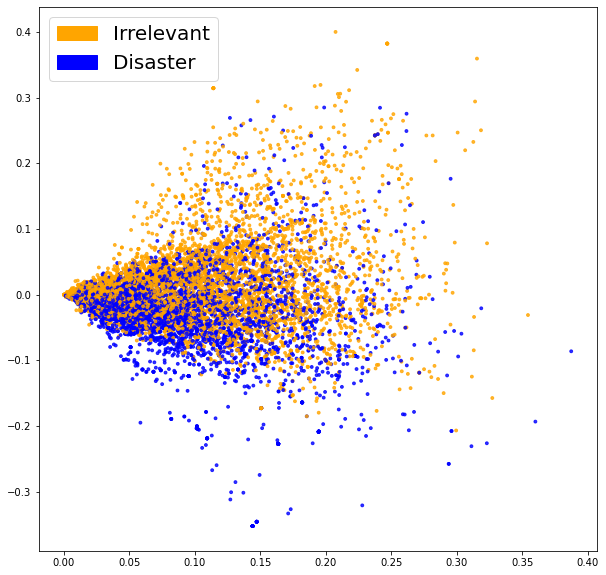

In [ ]:
# Construindo bag-of-words com count-vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Plotando a distribuição do vocabulário
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

#Treinando o modelo com o vocabulário construindo e as variáveis alvo
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


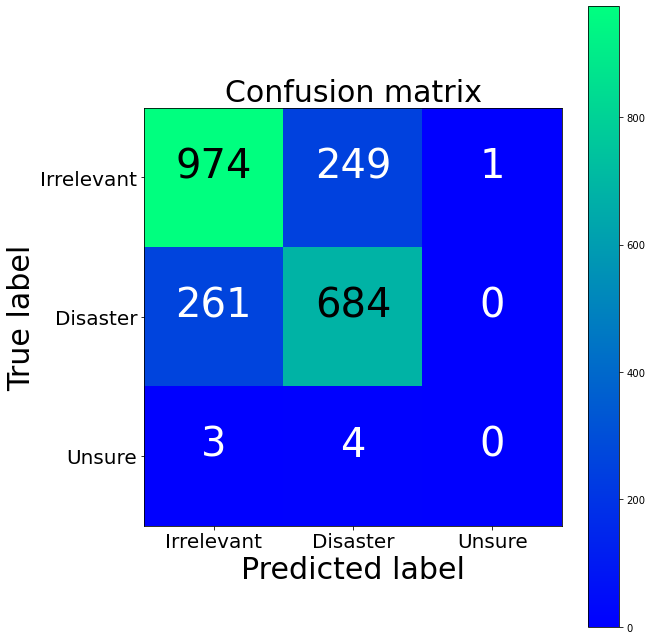

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

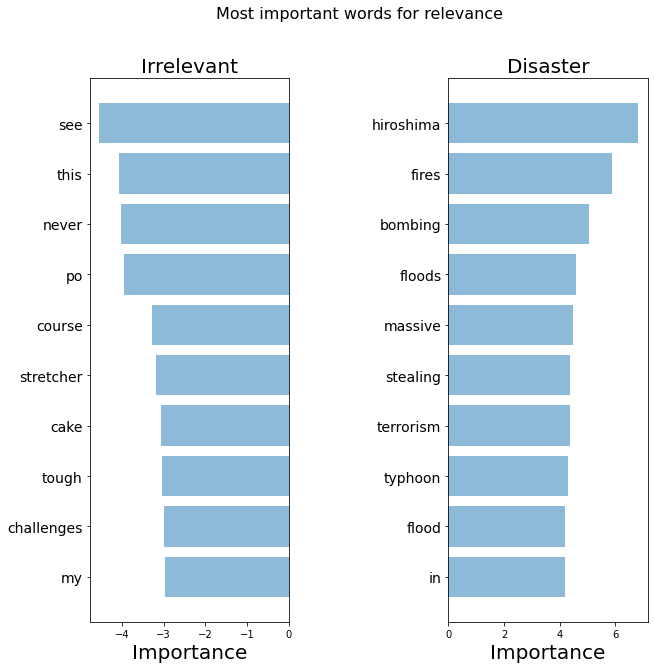

In [ ]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


In [ ]:
#Treinando a matriz de relação com notícias do Google
#O conjunto de dados para treinar a matriz pode ser acessado em: 
#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
word2vec_path = r"C:\Users\User\Documents\Nlp\GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
#Método para calcular a distância semântica entre as palavras
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

#Montagem do arquivo de treinamento contento a relação semântica entre as palavras
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)
    embeddings = get_word2vec_embeddings(word2vec, clean_questions)

    X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=40)
    fig = plt.figure(figsize=(10, 10))          
    plot_LSA(embeddings, list_labels)
    plt.show()

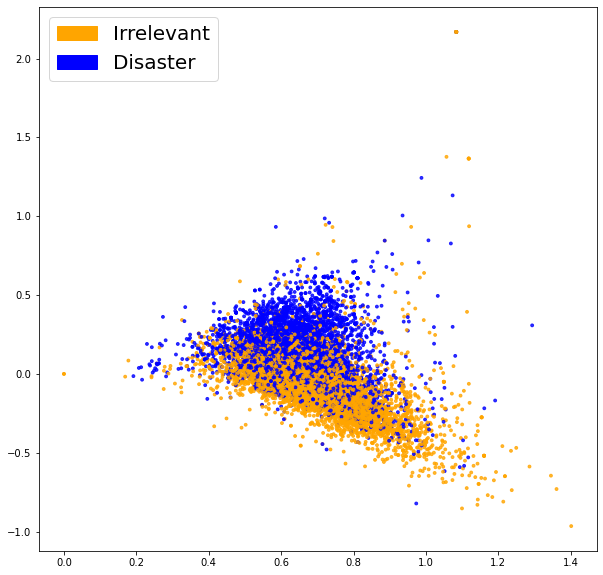

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=40)
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)

clf_w2v.fit(X_train_word2vec, y_train_word2vec)

y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.777, precision = 0.776, recall = 0.777, f1 = 0.777


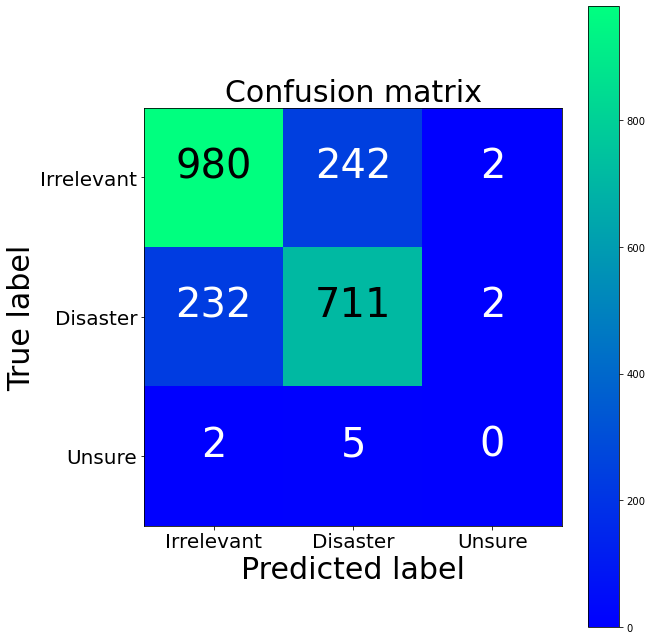

Word2Vec confusion matrix
[[980 242   2]
 [232 711   2]
 [  2   5   0]]
TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(9, 9))
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)